In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
path = (
    "/home/nils/projects/uq-method-box/experiments/experiments/exp_results/results.csv"
)

df = pd.read_csv(path)

meta_cols = [
    "base_model",
    "loss_fn",
    "ensemble",
    "ensemble_members",
    "conformalized",
    "dataset_name",
    "pred_log_dir",
    "mlp_n_outputs",
    "date",
    "seed",
]

# Preprocessing

In [6]:
# drop duplicate experiments and keep the one with the latest date
df = (
    df.sort_values("date")
    .drop_duplicates(meta_cols, keep="last")
    .reset_index(drop=True)
)
df["ensemble"] = df["ensemble"].fillna("None")  # should be handled when saving the dict
df = df[
    df["loss_fn"] != "quantile"
]  # discovered something wrong with quantile loss with huge nll so exclude at the moment

df["model_plot_name"] = (
    df["base_model"] + "_" + df["loss_fn"] + "_" + df["ensemble"]
)  # TODO come up with a unique model name for us to make easy plotting
df

,nll,crps,check,interval,rms_cal,ma_cal,miscal_area,sharp,mae,rmse,...,loss_fn,ensemble,ensemble_members,conformalized,dataset_name,pred_log_dir,mlp_n_outputs,date,seed,model_plot_name
0,0.760300,0.270352,0.136281,1.660729,0.059802,0.050232,0.050680,0.324313,0.347060,0.662568,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,8,gaussian_nll_None
1,0.707128,0.269761,0.136001,1.644956,0.045543,0.038604,0.038699,0.336026,0.349960,0.661949,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,12,gaussian_nll_None
2,0.738563,0.275056,0.138655,1.682910,0.047357,0.038182,0.038243,0.334496,0.359060,0.670967,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,11,gaussian_nll_None
3,0.724148,0.273447,0.137863,1.656366,0.045651,0.033773,0.033649,0.343745,0.354055,0.663135,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,10,gaussian_nll_None
4,0.800127,0.277526,0.139914,1.688355,0.075351,0.064029,0.064534,0.326181,0.361242,0.659299,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,9,gaussian_nll_None
5,0.712266,0.269173,0.135690,1.633306,0.056760,0.042799,0.042969,0.334909,0.353055,0.661659,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,15,gaussian_nll_None
6,0.704513,0.271416,0.136855,1.620621,0.062753,0.055377,0.055812,0.337952,0.359289,0.649154,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,7,gaussian_nll_None
7,0.637729,0.265047,0.133642,1.589657,0.044064,0.039869,0.040128,0.338940,0.351794,0.644444,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,6,gaussian_nll_None
8,0.707311,0.267128,0.134659,1.643251,0.046475,0.038425,0.038454,0.323132,0.346594,0.657039,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,5,gaussian_nll_None
9,0.615091,0.262144,0.132166,1.586793,0.032309,0.026726,0.026695,0.341062,0.344496,0.653843,...,nll,None,1,False,boston,experiments/experiments/test_sgd_gaussian_03-2...,2,2023-03-28 11:06:32,4,gaussian_nll_None


In [7]:
df.columns

Index(['nll', 'crps', 'check', 'interval', 'rms_cal', 'ma_cal', 'miscal_area',
       'sharp', 'mae', 'rmse', 'mdae', 'marpd', 'r2', 'corr', 'base_model',
       'loss_fn', 'ensemble', 'ensemble_members', 'conformalized',
       'dataset_name', 'pred_log_dir', 'mlp_n_outputs', 'date', 'seed',
       'model_plot_name'],
      dtype='object')

# Evaluate All Models across seeds on one dataset

This is in line with the plots in the Bayesian Wilson paper that we want to reproduce.

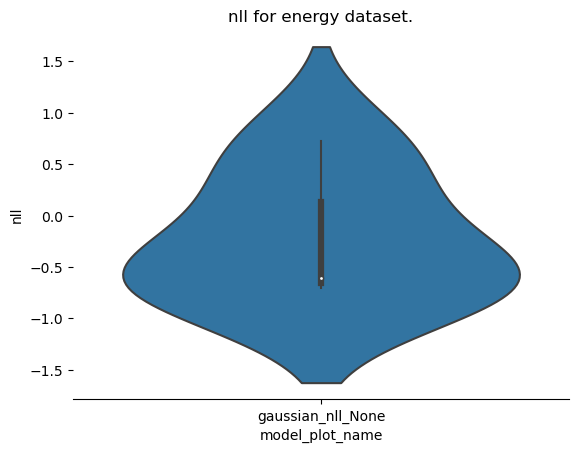

In [8]:
def evaluate_all_models_one_ds(
    dataset_name: str, metric: str, df: pd.DataFrame
) -> None:
    """Evaluate all models on a single dataset.

    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize

    """
    dataset_df = df[df["dataset_name"] == dataset_name]
    dataset_df = dataset_df.drop_duplicates(
        ["base_model", "loss_fn", "ensemble", "seed"]
    ).reset_index(drop=True)
    dataset_df["model_plot_name"] = (
        dataset_df["base_model"]
        + "_"
        + dataset_df["loss_fn"]
        + "_"
        + dataset_df["ensemble"]
    )

    sns.violinplot(data=dataset_df, x="model_plot_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {dataset_name} dataset.")


evaluate_all_models_one_ds("energy", "nll", df)

# Evaluate a single model across datasets

This might be useful to check indidivual model performance and see what is going on.

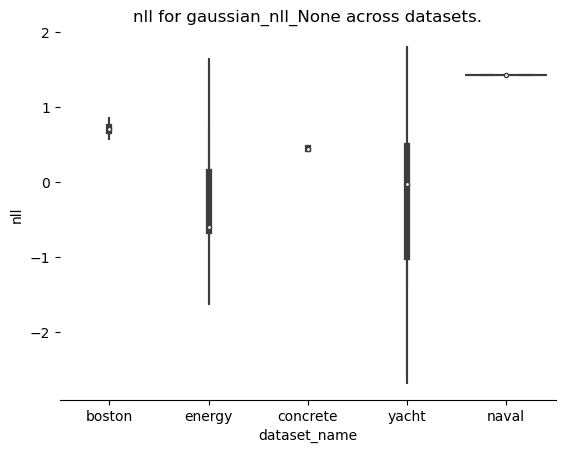

In [9]:
def evaluate_all_models_one_ds(model_name: str, metric: str, df: pd.DataFrame) -> None:
    """Evaluate all models on a single dataset.

    Args:
        dataset_name: name of dataset for which to plot results
        metric: name of the metric to visualize

    """
    dataset_df = df[df["model_plot_name"] == model_name]
    dataset_df = dataset_df.drop_duplicates(
        ["base_model", "loss_fn", "ensemble", "seed", "dataset_name"]
    ).reset_index(drop=True)

    sns.violinplot(data=dataset_df, x="dataset_name", y=metric)
    sns.despine(left=True)
    plt.title(f"{metric} for {model_name} across datasets.")


evaluate_all_models_one_ds("gaussian_nll_None", "nll", df)

# Big Tables with numbers

Here we can autogenerate summary table for different things and also convert them to latex.

In [10]:
df["pred_log_dir"][30]

'experiments/experiments/test_sgd_gaussian_04-03-2023_12-53-10/seed_1'

In [11]:
# TODO code here
df.select_dtypes(include=[np.number])
metric_columns = ["nll","crps", "check", "interval", "rms_cal", "ma_cal", "miscal_area", "sharp", "mae", "rmse", "mdae", "marpd", "r2", "corr"]
other_cols = list(set(df.columns) - set(metric_columns))

mean_df = df.groupby("pred_log_dir")[metric_columns].mean().reset_index()
std_df = df.groupby("pred_log_dir")[metric_columns].std().reset_index()
result_df = pd.merge(left=mean_df, right=std_df, how="left", left_on="pred_log_dir", right_on="pred_log_dir", suffixes=("_mean", "_std"))
result_df = pd.merge(left=result_df, right=df[other_cols].drop_duplicates(subset=["pred_log_dir"], keep="first"), how="left", left_on="pred_log_dir", right_on="pred_log_dir")

result_df

,pred_log_dir,nll_mean,crps_mean,check_mean,interval_mean,rms_cal_mean,ma_cal_mean,miscal_area_mean,sharp_mean,mae_mean,...,dataset_name,ensemble,mlp_n_outputs,model_plot_name,date,base_model,ensemble_members,seed,loss_fn,conformalized
0,experiments/experiments/test_sgd_gaussian_03-2...,0.702815,0.269742,0.135993,1.633063,0.052603,0.043077,0.043265,0.335649,0.352868,...,boston,None,2,gaussian_nll_None,2023-03-28 11:06:32,gaussian,1,8,nll,False
1,experiments/experiments/test_sgd_gaussian_04-0...,-0.221096,0.108216,0.054635,0.539148,0.124713,0.109079,0.110123,0.220033,0.153121,...,energy,None,2,gaussian_nll_None,2023-04-03 12:04:22,gaussian,1,4,nll,False
2,experiments/experiments/test_sgd_gaussian_04-0...,0.444093,0.217685,0.109914,1.104776,0.031181,0.024443,0.024425,0.411984,0.306982,...,concrete,None,2,gaussian_nll_None,2023-04-03 12:26:46,gaussian,1,4,nll,False
3,experiments/experiments/test_sgd_gaussian_04-0...,-0.287028,0.110956,0.056020,0.650808,0.253197,0.217061,0.219108,0.366237,0.111696,...,yacht,None,2,gaussian_nll_None,2023-04-03 12:53:10,gaussian,1,1,nll,False
4,experiments/experiments/test_sgd_gaussian_04-1...,1.426669,0.588763,0.297304,2.701149,0.084562,0.074488,0.075160,1.000115,0.876777,...,naval,None,2,gaussian_nll_None,2023-04-12 14:18:17,gaussian,1,4,nll,False


# Create pretty table

In comparision to the results reported in the Subspace Inference paper, "nll" corresponds to (-1)*"normalized test loglikelihood" and "rmse" corresponds to "normalized test rmse".

In [12]:
metrics_to_show = ["nll", "rmse"]

dataset_names = result_df["dataset_name"].unique()
model_names = result_df["model_plot_name"].unique()

for metric in metrics_to_show:
    plot_df = result_df.copy()
    plot_df["metric"] = plot_df[metric+"_mean"].round(4).astype(str) + " (" + plot_df[metric+"_std"].round(4).astype(str) + ")"
    plot_df = plot_df.pivot(index="dataset_name", columns="model_plot_name", values="metric")
    plot_df.columns.rename(metric, inplace=True)
    print(plot_df)
    print("")

nll          gaussian_nll_None
dataset_name                  
boston         0.7028 (0.0436)
concrete       0.4441 (0.0138)
energy         -0.2211 (0.632)
naval             1.4267 (0.0)
yacht          -0.287 (0.8775)

rmse         gaussian_nll_None
dataset_name                  
boston         0.6557 (0.0089)
concrete        0.4055 (0.002)
energy         0.2151 (0.0301)
naval             1.0077 (0.0)
yacht          0.1614 (0.0583)

